In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [36]:
# Load datasets
combats = pd.read_csv("datasets/combats.csv")
pokemon = pd.read_csv("datasets/pokemon.csv")
test_data = pd.read_csv("datasets/tests.csv")

In [37]:
# Create a dictionary mapping Pokémon ID to their stats and types
pokemon_dict = pokemon.set_index("#").to_dict(orient="index")

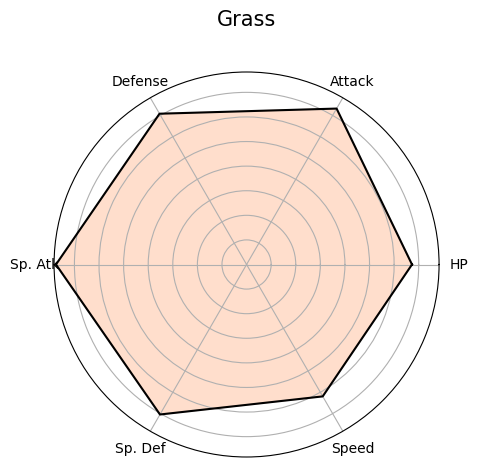

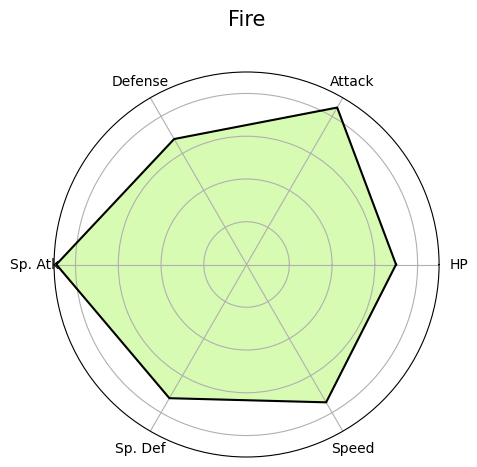

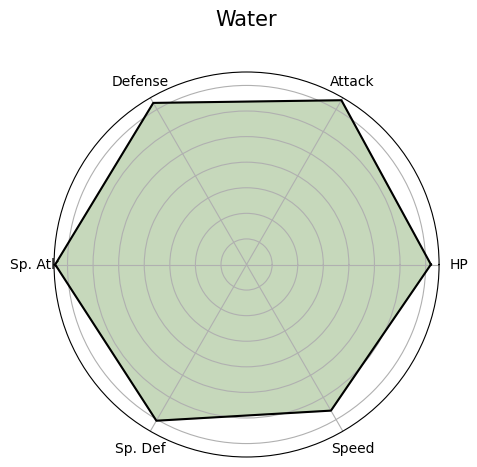

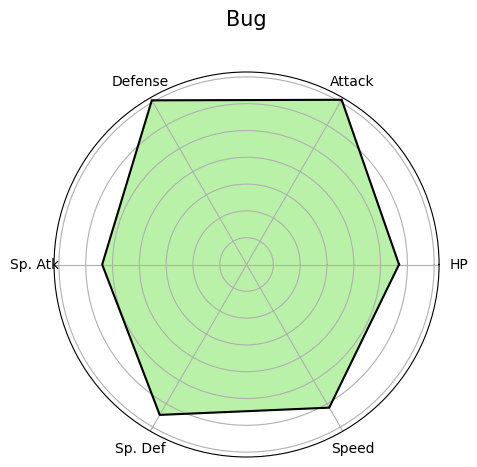

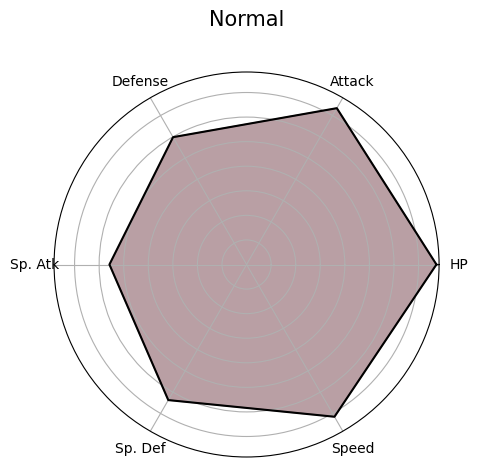

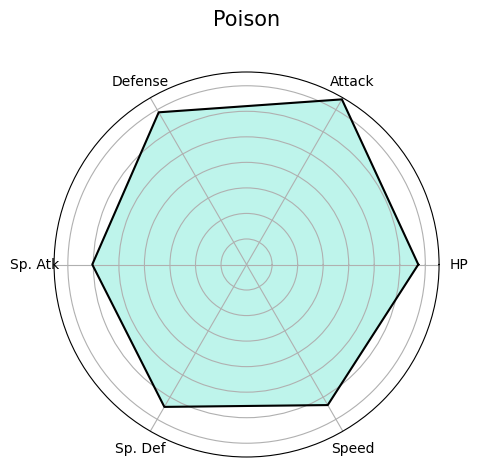

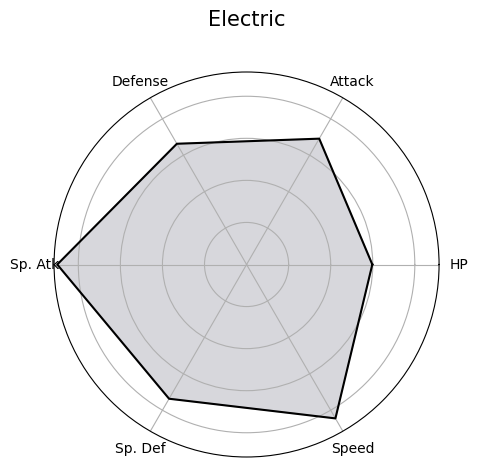

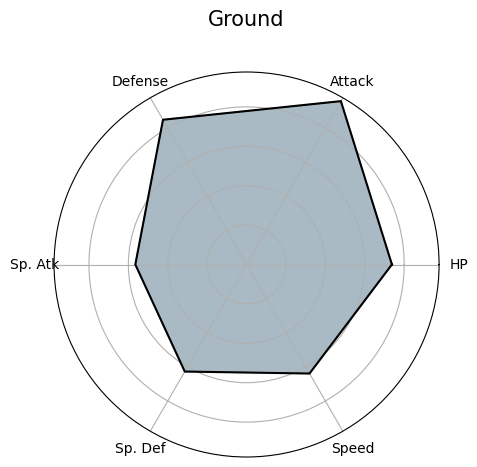

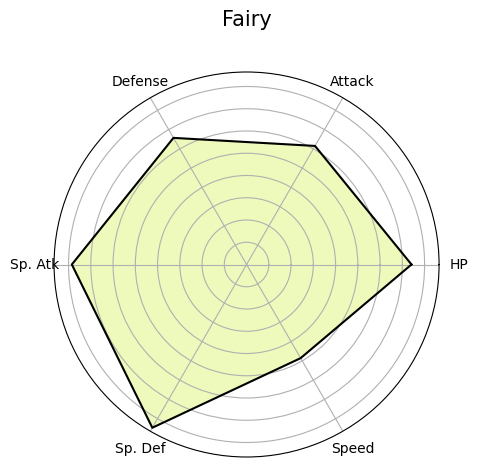

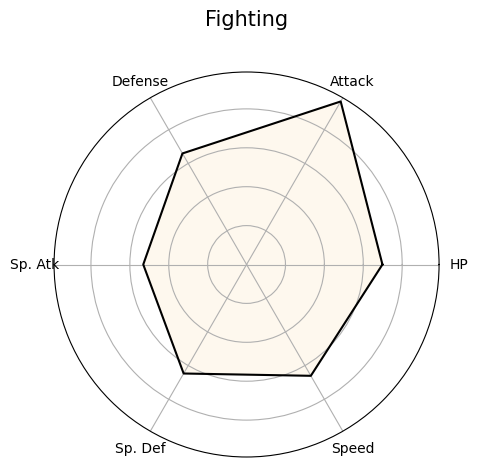

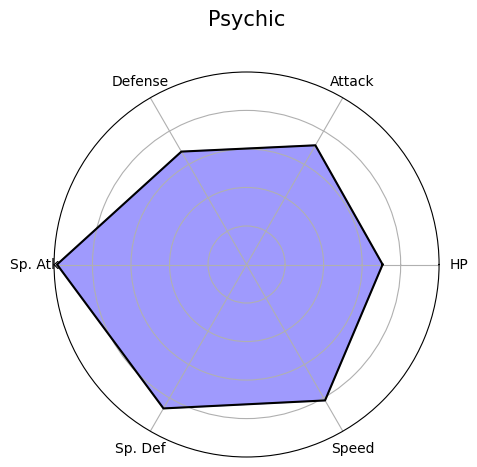

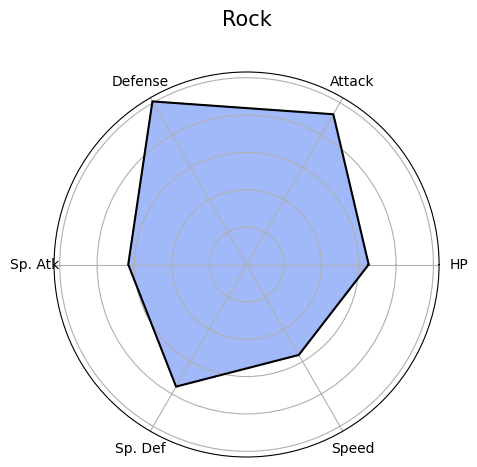

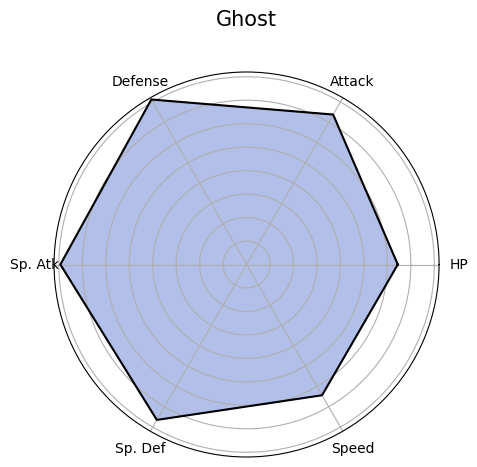

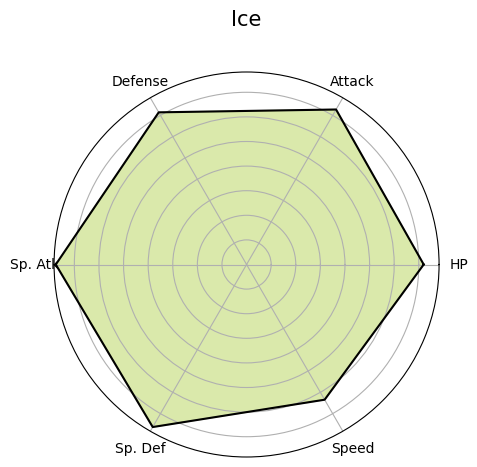

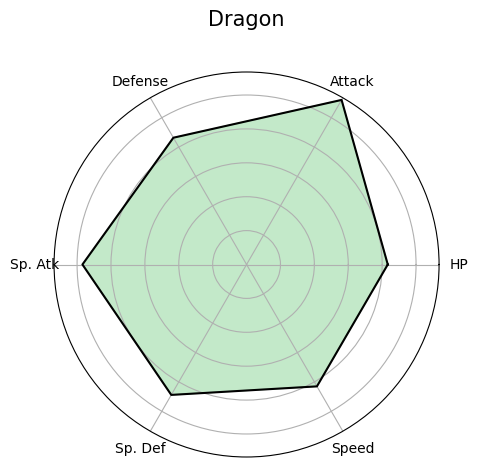

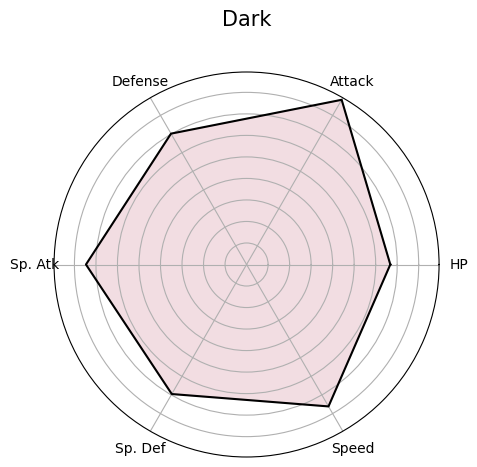

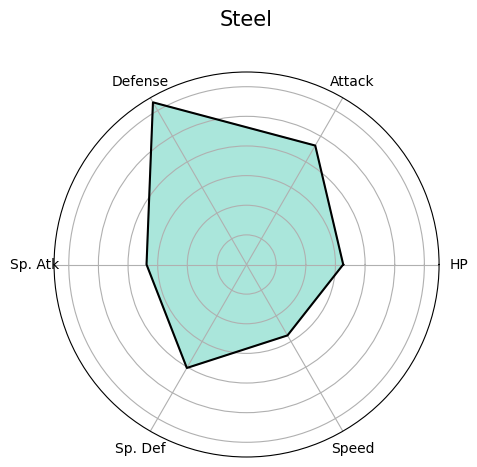

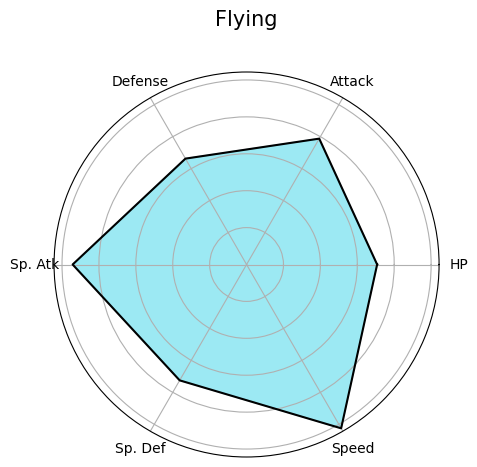

In [38]:
# List of stats to visualize
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

# Get unique primary types
types = pokemon["Type 1"].unique()

# Function to create radar chart
def plot_radar_chart(type_name, stats_mean):
    angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False).tolist()
    stats_mean += stats_mean[:1]  # Close the radar chart loop
    angles += angles[:1]  

    # Create figure
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.fill(angles, stats_mean, color=np.random.rand(3,), alpha=0.4)
    ax.plot(angles, stats_mean, color='black', linewidth=1.5)
    
    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stats)

    # Title
    plt.title(type_name, size=15, color="black", y=1.1)
    plt.show()

# Generate radar chart for each Pokémon type
for t in types:
    type_df = pokemon[pokemon["Type 1"] == t]
    stats_mean = type_df[stats].mean().tolist()
    plot_radar_chart(t, stats_mean)

In [39]:
# Pokémon type effectiveness matrix
type_chart = {
    "Normal": {"Rock": 0.5, "Ghost": 0, "Steel": 0.5},
    "Fire": {"Fire": 0.5, "Water": 0.5, "Grass": 2, "Ice": 2, "Bug": 2, "Rock": 0.5, "Dragon": 0.5, "Steel": 2},
    "Water": {"Fire": 2, "Water": 0.5, "Grass": 0.5, "Ground": 2, "Rock": 2, "Dragon": 0.5},
    "Electric": {"Water": 2, "Electric": 0.5, "Grass": 0.5, "Ground": 0, "Flying": 2, "Dragon": 0.5},
    "Grass": {"Fire": 0.5, "Water": 2, "Grass": 0.5, "Poison": 0.5, "Ground": 2, "Flying": 0.5, "Bug": 0.5, "Rock": 2, "Dragon": 0.5, "Steel": 0.5},
    "Ice": {"Fire": 0.5, "Water": 0.5, "Ice": 0.5, "Grass": 2, "Ground": 2, "Flying": 2, "Dragon": 2, "Steel": 0.5},
    "Fighting": {"Normal": 2, "Ice": 2, "Rock": 2, "Dark": 2, "Steel": 2, "Poison": 0.5, "Flying": 0.5, "Psychic": 0.5, "Bug": 0.5, "Fairy": 0.5, "Ghost": 0},
    "Poison": {"Grass": 2, "Poison": 0.5, "Ground": 0.5, "Rock": 0.5, "Ghost": 0.5, "Steel": 0},
    "Ground": {"Fire": 2, "Electric": 2, "Grass": 0.5, "Poison": 2, "Flying": 0, "Bug": 0.5, "Rock": 2, "Steel": 2},
    "Flying": {"Electric": 0.5, "Grass": 2, "Fighting": 2, "Bug": 2, "Rock": 0.5, "Steel": 0.5},
    "Psychic": {"Fighting": 2, "Poison": 2, "Psychic": 0.5, "Dark": 0, "Steel": 0.5},
    "Bug": {"Fire": 0.5, "Grass": 2, "Fighting": 0.5, "Poison": 0.5, "Flying": 0.5, "Psychic": 2, "Ghost": 0.5, "Dark": 2, "Steel": 0.5, "Fairy": 0.5},
    "Rock": {"Fire": 2, "Ice": 2, "Fighting": 0.5, "Ground": 0.5, "Flying": 2, "Bug": 2, "Steel": 0.5},
    "Ghost": {"Normal": 0, "Psychic": 2, "Dark": 0.5, "Ghost": 2},
    "Dragon": {"Dragon": 2, "Steel": 0.5, "Fairy": 0},
    "Dark": {"Fighting": 0.5, "Psychic": 2, "Dark": 0.5, "Fairy": 0.5},
    "Steel": {"Fire": 0.5, "Water": 0.5, "Electric": 0.5, "Ice": 2, "Rock": 2, "Steel": 0.5, "Fairy": 2},
    "Fairy": {"Fighting": 2, "Poison": 0.5, "Steel": 0.5, "Dark": 2, "Dragon": 2}
}

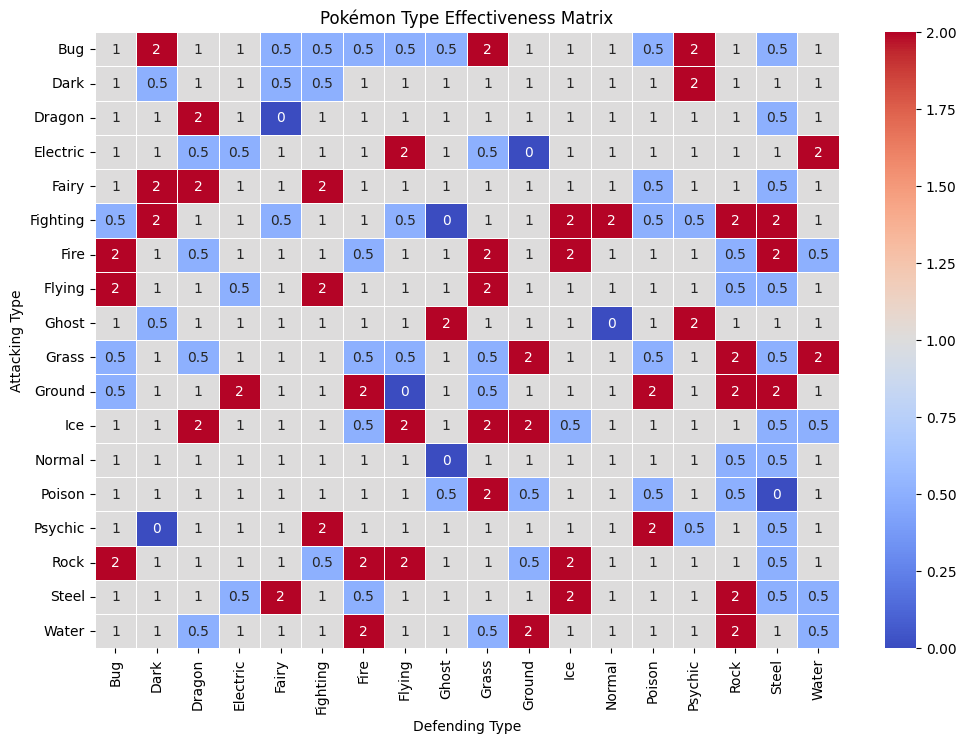

In [40]:
# Convert the dictionary to a DataFrame
all_types = sorted(set(type_chart.keys()) | {t for effects in type_chart.values() for t in effects})
df = pd.DataFrame(1.0, index=all_types, columns=all_types)  # Default effectiveness is 1

# Fill in effectiveness values
for attack_type, targets in type_chart.items():
    for target_type, effectiveness in targets.items():
        df.at[attack_type, target_type] = effectiveness

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap="coolwarm", linewidths=0.5, cbar=True)

plt.title("Pokémon Type Effectiveness Matrix")
plt.xlabel("Defending Type")
plt.ylabel("Attacking Type")

plt.show()

In [41]:
# Function to calculate type effectiveness
def get_type_effectiveness(attacker_type1, attacker_type2, defender_type1, defender_type2):
    effectiveness = 1.0
    for atk_type in [attacker_type1, attacker_type2]:
        if pd.isna(atk_type):
            continue
        for def_type in [defender_type1, defender_type2]:
            if pd.isna(def_type):
                continue
            effectiveness *= type_chart.get(atk_type, {}).get(def_type, 1.0)
    return effectiveness

In [42]:
# Feature engineering
def get_features(row):
    p1 = pokemon_dict[row["First_pokemon"]]
    p2 = pokemon_dict[row["Second_pokemon"]]

    type_effectiveness = get_type_effectiveness(p1["Type 1"], p1["Type 2"], p2["Type 1"], p2["Type 2"])

    return [
        p1["HP"], p1["Attack"], p1["Defense"], p1["Sp. Atk"], p1["Sp. Def"], p1["Speed"], int(p1["Legendary"]),
        p2["HP"], p2["Attack"], p2["Defense"], p2["Sp. Atk"], p2["Sp. Def"], p2["Speed"], int(p2["Legendary"]),
        type_effectiveness
    ]

In [43]:
# Prepare training data
X = combats.apply(get_features, axis=1).tolist()
y = (combats["Winner"] == combats["First_pokemon"]).astype(int)  # 1 if First_pokemon wins, else 0


In [44]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Train the Decision Tree model
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [47]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9435


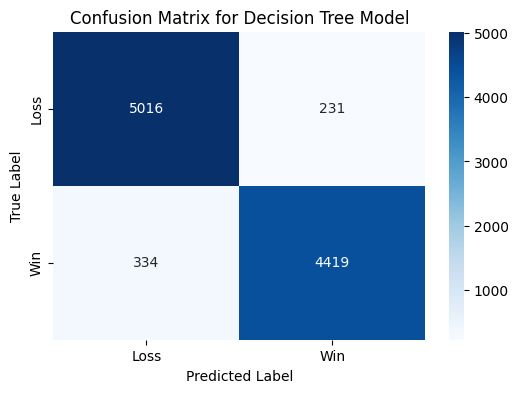

Model Accuracy: 0.94


In [48]:
# Step 1: Make Predictions
y_pred = model.predict(X_test)

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

# Step 4: Print Accuracy (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

In [49]:
# Prepare test predictions
test_features = np.array(test_data.apply(get_features, axis=1).tolist())
test_predictions = model.predict(test_features)

In [50]:
# Save results
test_data["Winner"] = test_data["First_pokemon"] * test_predictions + test_data["Second_pokemon"] * (1 - test_predictions)
test_data.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv


In [51]:
test_data["Winner"] = test_data["First_pokemon"] * test_predictions.flatten() + test_data["Second_pokemon"] * (1 - test_predictions.flatten())
test_data.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv
